In [1]:
import obspy
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm,trange

from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client

from libcomcat.dataframes import get_phase_dataframe
from libcomcat.search import get_event_by_id

import matplotlib.pyplot as plt

In [2]:
from obspy.clients.fdsn import RoutingClient
client = Client("ncedc")
#client = RoutingClient("iris-federator")

In [3]:
lat=36.69
lon=-122.17
minr=0.0
maxr=0.6
level='channel'
#start='2021-06-21T00:00:00'
#end='2021-06-26T00:00:00'

start='2021-06-21T00:00:00'
end='2021-06-26T00:00:00'

fmat = 'xml'

In [4]:
UTCDateTime(start).julday

172

In [5]:
channel = 'HH?'
network = 'BK'
station = 'SAO'

In [6]:
sta_inventory = client.get_stations(starttime=start,
                                    endtime=end,
                                    latitude=lat,
                                    longitude=lon,
                                    minradius=minr,
                                    maxradius=maxr,
                                    level=level,
                                    channel = channel,
                                    network = network,
                                    station = station,
                                    format=fmat)

In [7]:
channel = sta_inventory.get_contents()['channels']

In [8]:
channel_reorder = ['.'.join( [ch.split('.')[0],ch.split('.')[1],ch.split('.')[3],ch.split('.')[2]] ) for ch in channel]

In [9]:
for i,ch in enumerate(channel):
    
    sta_coordinates = sta_inventory.get_channel_metadata(ch)
    sta_temp_df = pd.DataFrame(sta_coordinates,index=[i])
    
    if i==0:
        sta_df = sta_temp_df
    else:
        sta_df = pd.concat([sta_df,sta_temp_df])

In [10]:
sta_df['station'] = channel

In [11]:
sta_df

,latitude,longitude,elevation,local_depth,azimuth,dip,station
0,36.76403,-121.44722,317.2,3.0,90.0,0.0,BK.SAO.00.HHE
1,36.76403,-121.44722,317.2,3.0,0.0,0.0,BK.SAO.00.HHN
2,36.76403,-121.44722,317.2,3.0,0.0,-90.0,BK.SAO.00.HHZ


In [12]:
otime = UTCDateTime('2021-06-20T00:00:00')
endtime = UTCDateTime('2021-06-21T00:00:00')

In [13]:
bulk = []
for i in range(len(sta_df)):
    
    net = sta_df.station[i].split('.')[0]
    sta = sta_df.station[i].split('.')[1]
    loc = sta_df.station[i].split('.')[2]
    cha = sta_df.station[i].split('.')[3]
    
    query_tuple = (net,sta,loc,cha,otime,endtime)
    bulk.append(query_tuple)

In [14]:
st = client.get_waveforms_bulk(bulk,attach_response=True)

In [15]:
st

3 Trace(s) in Stream:
BK.SAO.00.HHE | 2021-06-20T00:00:00.008393Z - 2021-06-20T23:59:59.998393Z | 100.0 Hz, 8640000 samples
BK.SAO.00.HHN | 2021-06-20T00:00:00.008394Z - 2021-06-20T23:59:59.998394Z | 100.0 Hz, 8640000 samples
BK.SAO.00.HHZ | 2021-06-20T00:00:00.008393Z - 2021-06-20T23:59:59.998393Z | 100.0 Hz, 8640000 samples

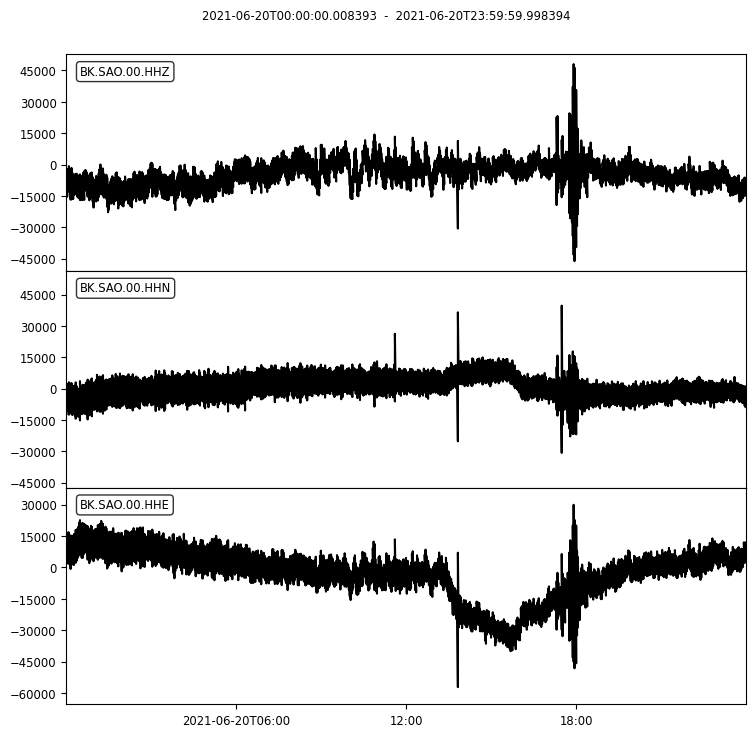

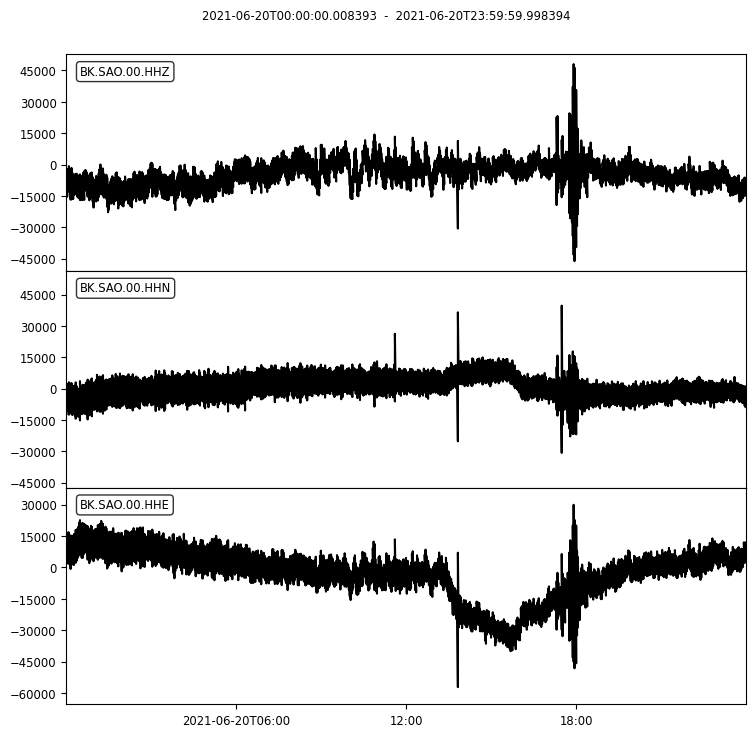

In [16]:
st.plot()

In [17]:
pre_filt = [0.0003, 0.0005, 45, 50] # filtering range when instrment reponse is corrected

In [18]:
st.detrend('linear') # remove linear trend
st.detrend("demean") # demean
st.taper(0.05) # cosin taper

3 Trace(s) in Stream:
BK.SAO.00.HHE | 2021-06-20T00:00:00.008393Z - 2021-06-20T23:59:59.998393Z | 100.0 Hz, 8640000 samples
BK.SAO.00.HHN | 2021-06-20T00:00:00.008394Z - 2021-06-20T23:59:59.998394Z | 100.0 Hz, 8640000 samples
BK.SAO.00.HHZ | 2021-06-20T00:00:00.008393Z - 2021-06-20T23:59:59.998393Z | 100.0 Hz, 8640000 samples

In [19]:
st = st.remove_response(output="VEL", pre_filt=pre_filt, water_level=None)

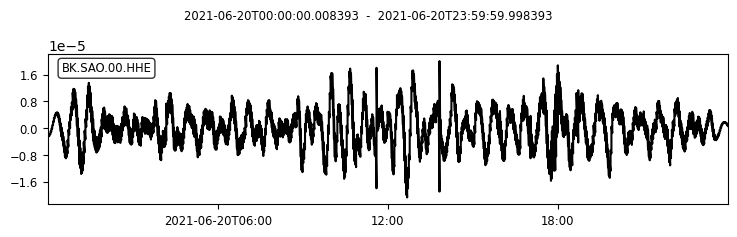

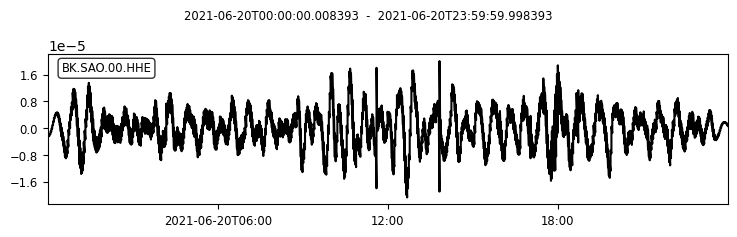

In [20]:
st[0].plot()

In [21]:
def stream2array(stream):
    '''
    populates a 2D np.array that is the traces as rows by the samples as cols
    '''
    import numpy as np
    import obspy
    array=np.empty((len(stream),len(stream[0].data)),dtype=float) # initialize
    for index,trace in enumerate(stream):
        array[index,:]=trace.data
    return array

def array2stream(array,oldStream):
    import numpy as np
    import obspy
    stream = obspy.Stream()
    for i,row in enumerate(array):
        trace = obspy.Trace(data=row)
        trace.stats = oldStream[i].stats
        stream += trace
    return stream

In [22]:
def spectra(stream,kind='psd',trace=99999):
    
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.integrate import cumtrapz
    
    if trace==99999:
        A = stream2array(stream)*0
        #A = np.array(stream)
        nx,nt = np.shape(A)
        nyq = nt//2
        dt = stream[0].stats.delta
        A = A[:,slice(1,nyq)]
        for i,tr in enumerate(stream.copy()):
            fr = np.fft.fftfreq(nt,d=dt)[slice(1,nyq)]
            A[i,:] = np.fft.fft(tr.data)[slice(1,nyq)] # #   e/s or e
        if kind=='as':
            sp = np.abs(A.T)
            sp = 10*np.log10(sp)
        if kind=='ps':
            sp = 2*(np.abs(A.T)**2) / (nt**2)
            sp = 10*np.log10(sp)
        if kind=='psd':
            sp = 2*(np.abs(A.T)**2) / (nt**2) * dt * nt
            sp = 10*np.log10(sp)

    else:
        nt = len(stream[trace].data)
        nyq = nt//2
        dt = stream[trace].stats.delta
        fr = np.fft.fftfreq(nt,d=dt)[slice(1,nyq)]
        A = np.fft.fft(stream[trace].data)[slice(1,nyq)]
        if kind=='as':
            sp = np.abs(A)
            sp = 10*np.log10(sp)
        if kind=='ps':
            sp = 2*(np.abs(A)**2) / (nt**2)
            sp = 10*np.log10(sp)
        if kind=='psd':
            sp = 2*(np.abs(A)**2) / (nt**2) * dt * nt
            sp = 10*np.log10(sp)

    return fr,sp

In [23]:
st

3 Trace(s) in Stream:
BK.SAO.00.HHE | 2021-06-20T00:00:00.008393Z - 2021-06-20T23:59:59.998393Z | 100.0 Hz, 8640000 samples
BK.SAO.00.HHN | 2021-06-20T00:00:00.008394Z - 2021-06-20T23:59:59.998394Z | 100.0 Hz, 8640000 samples
BK.SAO.00.HHZ | 2021-06-20T00:00:00.008393Z - 2021-06-20T23:59:59.998393Z | 100.0 Hz, 8640000 samples

In [63]:
windows_obspy = obspy.Stream() 

for windowed_st in st.slide(window_length=500.0, step=100.0):
    print(windowed_st)
    print("---") 
    windows_obspy += windowed_st.copy()[0]

3 Trace(s) in Stream:
BK.SAO.00.HHE | 2021-06-20T00:00:00.008393Z - 2021-06-20T00:08:20.008393Z | 100.0 Hz, 50001 samples
BK.SAO.00.HHN | 2021-06-20T00:00:00.008394Z - 2021-06-20T00:08:20.008394Z | 100.0 Hz, 50001 samples
BK.SAO.00.HHZ | 2021-06-20T00:00:00.008393Z - 2021-06-20T00:08:20.008393Z | 100.0 Hz, 50001 samples
---
3 Trace(s) in Stream:
BK.SAO.00.HHE | 2021-06-20T00:01:40.008393Z - 2021-06-20T00:10:00.008393Z | 100.0 Hz, 50001 samples
BK.SAO.00.HHN | 2021-06-20T00:01:40.008394Z - 2021-06-20T00:10:00.008394Z | 100.0 Hz, 50001 samples
BK.SAO.00.HHZ | 2021-06-20T00:01:40.008393Z - 2021-06-20T00:10:00.008393Z | 100.0 Hz, 50001 samples
---
3 Trace(s) in Stream:
BK.SAO.00.HHE | 2021-06-20T00:03:20.008393Z - 2021-06-20T00:11:40.008393Z | 100.0 Hz, 50001 samples
BK.SAO.00.HHN | 2021-06-20T00:03:20.008394Z - 2021-06-20T00:11:40.008394Z | 100.0 Hz, 50001 samples
BK.SAO.00.HHZ | 2021-06-20T00:03:20.008393Z - 2021-06-20T00:11:40.008393Z | 100.0 Hz, 50001 samples
---
3 Trace(s) in Stream:


In [64]:
windows_obspy[0:]

860 Trace(s) in Stream:

BK.SAO.00.HHE | 2021-06-20T00:00:00.008393Z - 2021-06-20T00:08:20.008393Z | 100.0 Hz, 50001 samples
...
(858 other traces)
...
BK.SAO.00.HHE | 2021-06-20T23:51:40.008393Z - 2021-06-20T23:59:59.998393Z | 100.0 Hz, 50000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [65]:
for i,tr in enumerate(windows_obspy):
    if i == len(windows_obspy)-1:
        break
    tr.trim(tr.stats.starttime,tr.stats.endtime-0.008)

In [66]:
windows_obspy.detrend('linear') # remove linear trend
windows_obspy.detrend("demean") # demean
windows_obspy.taper(0.05) # cosin taper

860 Trace(s) in Stream:

BK.SAO.00.HHE | 2021-06-20T00:00:00.008393Z - 2021-06-20T00:08:19.998393Z | 100.0 Hz, 50000 samples
...
(858 other traces)
...
BK.SAO.00.HHE | 2021-06-20T23:51:40.008393Z - 2021-06-20T23:59:59.998393Z | 100.0 Hz, 50000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [67]:
fr,psd = spectra(windows_obspy,kind='psd')

/Users/yuancong_gou/anaconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [68]:
fr.max()

49.997999999999998

In [69]:
fr.min()

0.002

Text(0, 0.5, 'Frequency [Hz]')

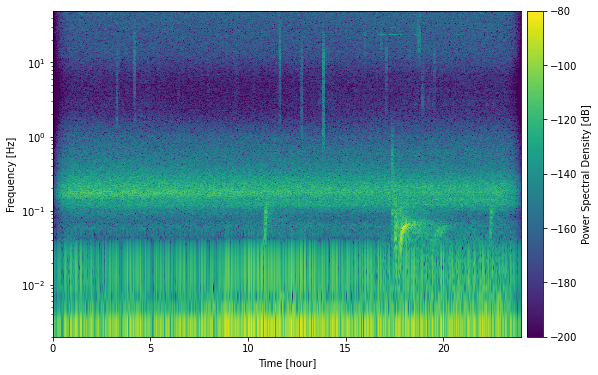

In [70]:
clim=[-200,-80]
cmap='viridis'
#cmap='magma'
units_plot='Power Spectral Density [dB]'

fig = plt.figure(figsize=(10,6))
extent=[0,24,min(fr),max(fr)]
plt.imshow(psd,extent=extent,aspect='auto',origin='lower',cmap=cmap,vmin=clim[0],vmax=clim[1])
h=plt.colorbar(label=units_plot,pad=0.01)
plt.yscale('log')
plt.xlabel('Time [hour]')
plt.ylabel('Frequency [Hz]')

Text(0, 0.5, 'Frequency [Hz]')

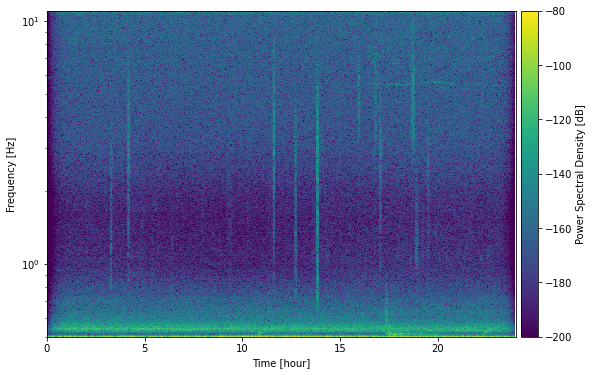

In [71]:
clim=[-200,-80]
cmap='viridis'
#cmap='magma'
units_plot='Power Spectral Density [dB]'

fig = plt.figure(figsize=(10,6))
extent=[0,24,0.5,11]
plt.imshow(psd,extent=extent,aspect='auto',origin='lower',cmap=cmap,vmin=clim[0],vmax=clim[1])
h=plt.colorbar(label=units_plot,pad=0.01)
plt.yscale('log')
plt.xlabel('Time [hour]')
plt.ylabel('Frequency [Hz]')

Text(0, 0.5, 'Frequency [Hz]')

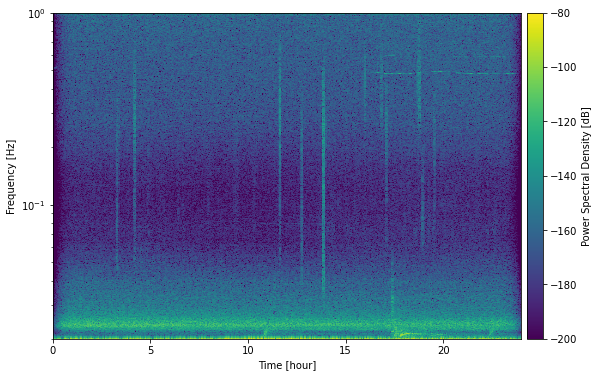

In [72]:
clim=[-200,-80]
cmap='viridis'
#cmap='magma'
units_plot='Power Spectral Density [dB]'

fig = plt.figure(figsize=(10,6))
extent=[0,24,0.02,1]
plt.imshow(psd,extent=extent,aspect='auto',origin='lower',cmap=cmap,vmin=clim[0],vmax=clim[1])
h=plt.colorbar(label=units_plot,pad=0.01)
plt.yscale('log')
plt.xlabel('Time [hour]')
plt.ylabel('Frequency [Hz]')

Text(0, 0.5, 'Frequency [Hz]')

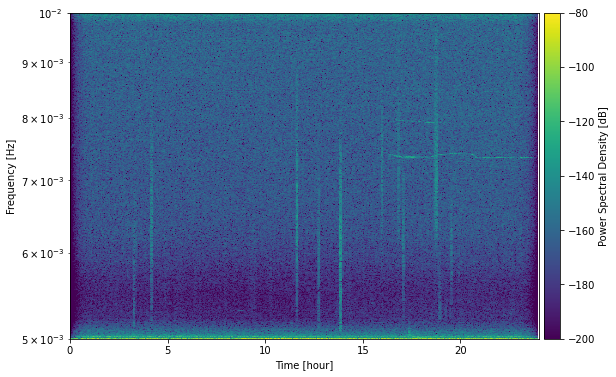

In [73]:
clim=[-200,-80]
cmap='viridis'
#cmap='magma'
units_plot='Power Spectral Density [dB]'

fig = plt.figure(figsize=(10,6))
extent=[0,24,0.005,0.01]
plt.imshow(psd,extent=extent,aspect='auto',origin='lower',cmap=cmap,vmin=clim[0],vmax=clim[1])
h=plt.colorbar(label=units_plot,pad=0.01)
plt.yscale('log')
plt.xlabel('Time [hour]')
plt.ylabel('Frequency [Hz]')

In [74]:
from obspy.signal import PPSD
from obspy.imaging.cm import pqlx
from obspy.imaging.cm import viridis_white_r

In [75]:
st

3 Trace(s) in Stream:
BK.SAO.00.HHE | 2021-06-20T00:00:00.008393Z - 2021-06-20T23:59:59.998393Z | 100.0 Hz, 8640000 samples
BK.SAO.00.HHN | 2021-06-20T00:00:00.008394Z - 2021-06-20T23:59:59.998394Z | 100.0 Hz, 8640000 samples
BK.SAO.00.HHZ | 2021-06-20T00:00:00.008393Z - 2021-06-20T23:59:59.998393Z | 100.0 Hz, 8640000 samples

In [76]:
# psd parameters

# psd estimate
#min_db = -200 # min. db 
#max_db = -50 # max db
ddb = 1 # 1 db increment

# MARS
min_db = -200 # min. db 
max_db = -80 # max db

# NL
#min_db = -130 # min. db 
#max_db = -20 # max db


#ppsd_length = 2*60*60 # 2 hour unit is seconds

ppsd_length = 120 # 100s
#ppsd_length = 20*60 # 20 min


In [77]:
# IR already removed

## wrong! This will convert to acceleration

paz = {'gain': 1.0,
       'poles': [],
       'sensitivity': 1,
       'zeros': []}

In [78]:
ppsd = PPSD(stats=st[0].stats, metadata=paz, db_bins=(min_db, max_db, ddb), ppsd_length=ppsd_length)
ppsd.add(st[0])

True

In [79]:
# plot parameters
period_low = 0.02 # 0.02 sec

period_max = 100 # 100 sec    0.01 HZ

In [80]:
plotOPT = 1

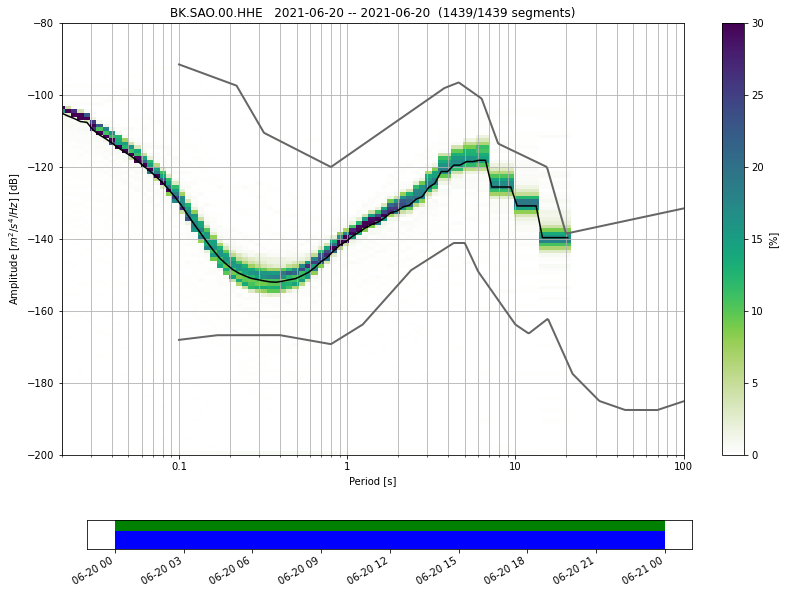

In [81]:
# plot
plt.rcParams['figure.figsize'] = 12,10

cmap = viridis_white_r
# plot 
if plotOPT:
    #ppsd.plot(cmap=pqlx, period_lim=(period_low, period_max), show_mean = True, )
    #ppsd.plot( period_lim=(period_low, period_max), show_mean = True, )
    
    ppsd.plot(cmap=cmap, period_lim=(period_low, period_max), show_mean = True, )